In [1]:
# Check if BiocManager is installed, if not, install it
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Install core Bioconductor packages if not already installed. 'force = FALSE' prevents re-installation if versions are current.
BiocManager::install(c("clusterProfiler", "ReactomePA", "pathview", "DESeq2", "tximport", "apeglm", "EnhancedVolcano", "org.Hs.eg.db"), force = FALSE)

# Install general R packages if not already installed
if (!requireNamespace("pheatmap", quietly = TRUE)) {
  install.packages("pheatmap")
}
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}

### Load core Bioconductor and other necessary R libraries

In [ ]:
# Load core Bioconductor and other necessary R libraries
library(clusterProfiler)
library(ReactomePA)
library(pathview)
library(pheatmap)
library(DESeq2)
library(tidyverse)
library(tximport)
library(apeglm)
library(EnhancedVolcano)
library(org.Hs.eg.db)

### Load the count data from the CSV file

In [45]:

count_data <- read.csv("/content/count_data.csv", row.names = 1)
# Display the first few rows of the count data to inspect its structure
head(count_data)

,NBS1_read,NBS2,NBS3,X26,IP2.53,X56_s,X83,X171,IP2.42,IP2.48,IP2.49,IP2.65,IP2.66,IP2.71,IP2.50,IP2.76,IP2.78,IP2.83,IP2.90
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,1578.00,1503.00,1623.00,571.00,379.00,432.00,122.00,355.00,652.00,230.00,105.00,228.00,128.00,82.00,267.00,247.0,307.00,441.00,165.00
ENSG00000000005,32.00,68.00,37.00,0.00,0.00,2.00,1.00,1.00,0.00,4.00,3.00,24.00,0.00,3.00,3.00,0.0,3.00,2.00,112.00
ENSG00000000419,723.99,637.05,733.00,1860.98,224.67,412.00,328.50,430.96,1786.87,490.29,641.62,354.00,776.40,297.31,621.04,414.0,370.00,551.80,412.00
ENSG00000000457,227.15,155.61,194.21,482.31,223.78,332.26,505.79,254.98,430.26,298.60,425.63,361.22,342.43,242.47,262.04,290.5,154.19,251.03,187.46
ENSG00000000460,92.85,132.39,100.79,565.69,137.22,266.74,323.21,218.02,419.74,174.40,166.40,161.78,159.57,122.53,251.96,106.5,110.94,120.97,186.54
ENSG00000000938,133.00,203.00,179.00,35.00,41.00,132.00,70.00,78.00,98.00,31.00,35.00,120.00,44.00,49.00,62.00,36.0,75.00,48.00,56.00


### Create metadata for the samples, mapping column names to conditions

In [46]:
metadata <- data.frame(
    row.names = colnames(count_data),
    condition = c(rep("Normal", 3), rep("HER2", 5), rep("NonTNBC", 6), rep("TNBC", 5))
)

# Inspect the created metadata
metadata

,condition
,<chr>
NBS1_read,Normal
NBS2,Normal
NBS3,Normal
X26,HER2
IP2.53,HER2
X56_s,HER2
X83,HER2
X171,HER2
IP2.42,NonTNBC


### Convert any non-integer values in the count data to integers by rounding,

In [47]:
# as DESeq2 requires integer counts.
count_data <- round(count_data)

### Create a DESeqDataSet object from the count matrix and metadata.

In [48]:
# The 'design' formula specifies the experimental design, here we are comparing different conditions.
dds <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = metadata,
                              design = ~ condition)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


### Pre-filtering step: Remove genes with very low counts across all samples.

In [49]:
# This helps to reduce the number of tests and improve statistical power.
dds <- dds[rowSums(counts(dds)) > 1, ]

In [50]:
# Run the DESeq2 analysis pipeline: normalization, dispersion estimation, and differential expression testing.
dds <- DESeq(dds)

# Extract normalized counts, which are useful for visualization and downstream analysis.
normalized_counts <- counts(dds, normalized = TRUE)

# Inspect the first few rows of the normalized counts
head(normalized_counts)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,NBS1_read,NBS2,NBS3,X26,IP2.53,X56_s,X83,X171,IP2.42,IP2.48,IP2.49,IP2.65,IP2.66,IP2.71,IP2.50,IP2.76,IP2.78,IP2.83,IP2.90
ENSG00000000003,845.81663,737.55041,742.36242,517.59737,792.30573,497.820482,167.44983,424.736759,399.63449,244.332288,103.472292,222.61908,118.41951,99.632826,272.959545,336.39190,390.168564,579.762310,232.4965
ENSG00000000005,17.15218,33.36888,16.92385,0.00000,0.00000,2.304724,1.37254,1.196442,0.00000,4.249257,2.956351,23.43359,0.00000,3.645103,3.066961,0.00000,3.812722,2.629308,157.8158
ENSG00000000419,388.06796,312.58790,335.27520,1686.95044,470.36620,474.773237,450.19300,515.666319,1095.31723,520.534004,632.659158,345.64541,717.91829,360.865236,634.860964,563.83095,470.235729,725.688877,580.5367
ENSG00000000457,121.67324,76.55214,88.73587,436.92107,468.27568,382.584259,694.50505,305.092601,263.56262,317.631974,419.801871,352.48021,316.40213,294.038340,267.847943,394.95405,195.719736,329.978095,263.4960
ENSG00000000460,49.84851,64.77489,46.19754,513.06499,286.40075,307.680714,443.33030,260.824263,257.43326,184.842687,163.584767,158.17671,148.02439,149.449239,257.624739,144.36251,141.070719,159.073105,263.4960
ENSG00000000938,71.28873,99.61592,81.87484,31.72663,85.71117,152.111814,96.07777,93.322443,60.06776,32.931743,34.490764,117.16794,40.70671,59.536689,63.383864,49.02878,95.318053,63.103381,78.9079


### Performing differential expression analysis for each cancer subtype against the 'Normal' condition.

In [51]:
# 'results' extracts the results table, specifying the contrast for comparison.
res_HER2_vs_Normal <- results(dds, contrast = c("condition", "HER2", "Normal"))
res_NonTNBC_vs_Normal <- results(dds, contrast = c("condition", "NonTNBC", "Normal"))
res_TNBC_vs_Normal <- results(dds, contrast = c("condition", "TNBC", "Normal"))

# Display a summary of the differential expression results for each comparison
summary(res_HER2_vs_Normal)
summary(res_NonTNBC_vs_Normal)
summary(res_TNBC_vs_Normal)


out of 48791 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9962, 20%
LFC < 0 (down)     : 5190, 11%
outliers [1]       : 333, 0.68%
low counts [2]     : 13242, 27%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 48791 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 11701, 24%
LFC < 0 (down)     : 4846, 9.9%
outliers [1]       : 333, 0.68%
low counts [2]     : 14188, 29%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 48791 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14060, 29%
LFC < 0 (down)     : 4813, 9.9%
outliers [1]       : 333, 0.68%
low counts [2]     : 11352, 23%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [52]:
# Order the differential expression results by adjusted p-value (padj) for easier inspection of most significant genes.
res_HER2_vs_Normal <- res_HER2_vs_Normal[order(res_HER2_vs_Normal$padj), ]
res_NonTNBC_vs_Normal <- res_NonTNBC_vs_Normal[order(res_NonTNBC_vs_Normal$padj), ]
res_TNBC_vs_Normal <- res_TNBC_vs_Normal[order(res_TNBC_vs_Normal$padj), ]

In [53]:
# Define significance thresholds for adjusted p-value and log2 fold change.
padj_threshold <- 0.05
log2fc_threshold <- 1

# Filter for significant differentially expressed genes (DEGs) based on the defined thresholds.
# HER2 vs Normal
sig_HER2_vs_Normal <- res_HER2_vs_Normal[which(res_HER2_vs_Normal$padj < padj_threshold & abs(res_HER2_vs_Normal$log2FoldChange) > log2fc_threshold), ]

# NonTNBC vs Normal
sig_NonTNBC_vs_Normal <- res_NonTNBC_vs_Normal[which(res_NonTNBC_vs_Normal$padj < padj_threshold & abs(res_NonTNBC_vs_Normal$log2FoldChange) > log2fc_threshold), ]

# TNBC vs Normal
sig_TNBC_vs_Normal <- res_TNBC_vs_Normal[which(res_TNBC_vs_Normal$padj < padj_threshold & abs(res_TNBC_vs_Normal$log2FoldChange) > log2fc_threshold), ]

# Display the first few significant DEGs for each comparison
head(sig_HER2_vs_Normal)
head(sig_NonTNBC_vs_Normal)
head(sig_TNBC_vs_Normal)

log2 fold change (MLE): condition HER2 vs Normal 
Wald test p-value: condition HER2 vs Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000277209   72961.4       13.12067  0.551644   23.7846 4.81530e-125
ENSG00000276168  434286.2       10.48966  0.452280   23.1929 5.37379e-119
ENSG00000277027   42538.5       11.14996  0.501859   22.2173 2.33516e-109
ENSG00000238741    2318.7        9.91269  0.499774   19.8343  1.50470e-87
ENSG00000274012  484701.7        9.18841  0.470321   19.5364  5.37977e-85
ENSG00000263934   34540.7       11.93466  0.621872   19.1915  4.35932e-82
                        padj
                   <numeric>
ENSG00000277209 1.69576e-120
ENSG00000276168 9.46217e-115
ENSG00000277027 2.74117e-105
ENSG00000238741  1.32474e-83
ENSG00000274012  3.78908e-81
ENSG00000263934  2.55863e-78

log2 fold change (MLE): condition NonTNBC vs Normal 
Wald test p-value: condition NonTNBC vs Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000277209  72961.42       13.33736  0.536280   24.8701 1.56676e-136
ENSG00000276168 434286.23       10.06127  0.437968   22.9726 8.75652e-117
ENSG00000277027  42538.55       10.24273  0.486519   21.0531  2.14261e-98
ENSG00000274012 484701.68        9.58100  0.455411   21.0382  2.93553e-98
ENSG00000278249   5528.63       10.27563  0.517582   19.8531  1.03525e-87
ENSG00000238741   2318.70        9.64524  0.490471   19.6653  4.27906e-86
                        padj
                   <numeric>
ENSG00000277209 5.36927e-132
ENSG00000276168 1.50043e-112
ENSG00000277027  2.44757e-94
ENSG00000274012  2.51502e-94
ENSG00000278249  7.09562e-84
ENSG00000238741  2.44406e-82

log2 fold change (MLE): condition TNBC vs Normal 
Wald test p-value: condition TNBC vs Normal 
DataFrame with 6 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue
                <numeric>      <numeric> <numeric> <numeric>    <numeric>
ENSG00000277209  72961.42       13.05633  0.551644   23.6680 7.69993e-124
ENSG00000276168 434286.23        9.35807  0.452281   20.6908  4.18785e-95
ENSG00000238741   2318.70        9.50084  0.499820   19.0085  1.44965e-80
ENSG00000278249   5528.63       10.04400  0.531133   18.9105  9.34552e-80
ENSG00000277027  42538.55        9.31186  0.501875   18.5541  7.54940e-77
ENSG00000274012 484701.68        8.69906  0.470322   18.4960  2.22459e-76
                        padj
                   <numeric>
ENSG00000277209 2.85714e-119
ENSG00000276168  7.76972e-91
ENSG00000238741  1.79303e-76
ENSG00000278249  8.66938e-76
ENSG00000277027  5.60256e-73
ENSG00000274012  1.37576e-72

In [54]:
# Save the tables of significant differentially expressed genes to CSV files for further analysis or record-keeping.
write.csv(sig_HER2_vs_Normal, file = "sig_HER2_vs_Normal.csv", row.names = TRUE)
write.csv(sig_NonTNBC_vs_Normal, file = "sig_NonTNBC_vs_Normal.csv", row.names = TRUE)
write.csv(sig_TNBC_vs_Normal, file = "sig_TNBC_vs_Normal.csv", row.names = TRUE)

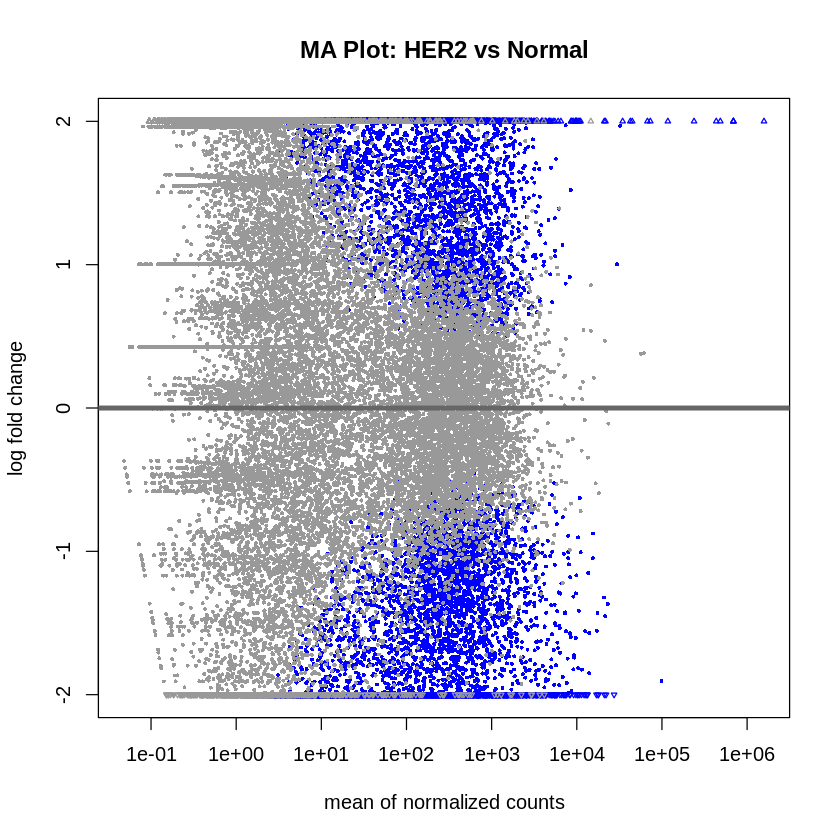

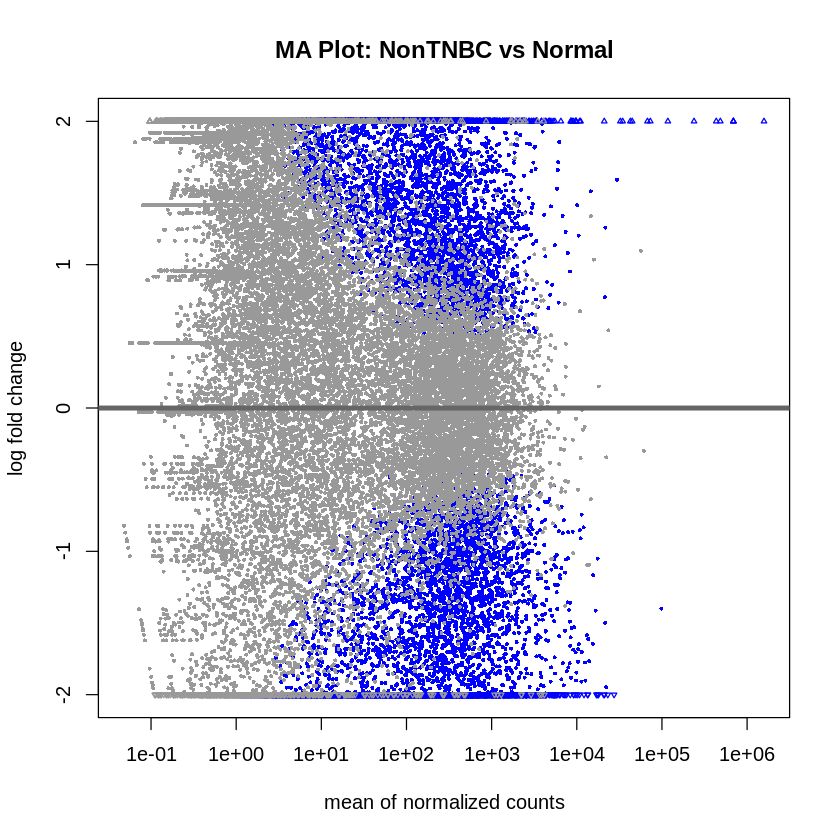

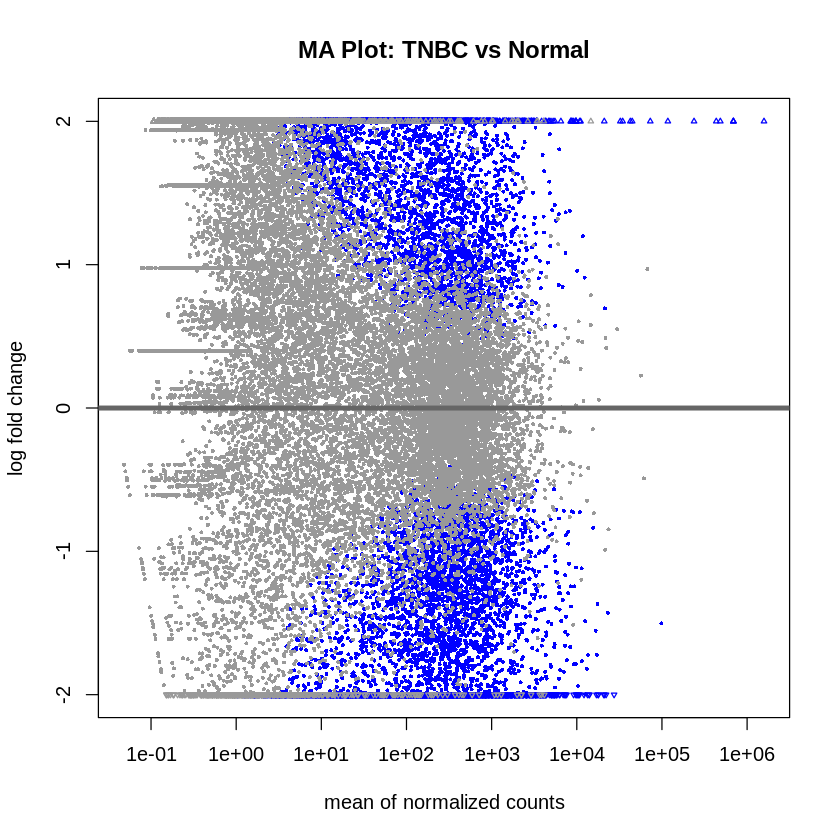

In [55]:
# Generate MA plots to visualize the log2 fold change against the mean of normalized counts.
# These plots help to identify genes with significant differential expression.
plotMA(res_HER2_vs_Normal, ylim = c(-2, 2), main = "MA Plot: HER2 vs Normal")
plotMA(res_NonTNBC_vs_Normal, ylim = c(-2, 2), main = "MA Plot: NonTNBC vs Normal")
plotMA(res_TNBC_vs_Normal, ylim = c(-2, 2), main = "MA Plot: TNBC vs Normal")

In [56]:
# Save the full differential expression results for HER2 vs Normal to a CSV file.
write.csv(res_HER2_vs_Normal, file = "res_HER2_vs_Normal.csv", row.names = TRUE)

In [57]:
# Extract the Ensembl gene IDs of the significant DEGs for each comparison.
gene_list_HER2 <- rownames(sig_HER2_vs_Normal)
gene_list_NonTNBC <- rownames(sig_NonTNBC_vs_Normal)
gene_list_TNBC <- rownames(sig_TNBC_vs_Normal)

In [58]:
# List valid key types for org.Hs.eg.db to ensure correct mapping during ID conversion.
valid_keys <- keys(org.Hs.eg.db, keytype = "SYMBOL")
head(valid_keys)

[1] "A1BG"     "A2M"      "NAT1"     "NAT2"     "NATP"     "SERPINA3"

### Print the head of each gene list to verify the extracted Ensembl IDs.

In [59]:

print("Head of gene_list_HER2:")
head(gene_list_HER2)

print("Head of gene_list_NonTNBC:")
head(gene_list_NonTNBC)

print("Head of gene_list_TNBC:")
head(gene_list_TNBC)

[1] "Head of gene_list_HER2:"


[1] "ENSG00000277209" "ENSG00000276168" "ENSG00000277027" "ENSG00000238741"
[5] "ENSG00000274012" "ENSG00000263934"

[1] "Head of gene_list_NonTNBC:"


[1] "ENSG00000277209" "ENSG00000276168" "ENSG00000277027" "ENSG00000274012"
[5] "ENSG00000278249" "ENSG00000238741"

[1] "Head of gene_list_TNBC:"


[1] "ENSG00000277209" "ENSG00000276168" "ENSG00000238741" "ENSG00000278249"
[5] "ENSG00000277027" "ENSG00000274012"

In [60]:
# Extract the list of significant gene names (Ensembl IDs)
gene_list_HER2 <- rownames(sig_HER2_vs_Normal)
gene_list_NonTNBC <- rownames(sig_NonTNBC_vs_Normal)
gene_list_TNBC <- rownames(sig_TNBC_vs_Normal)

# Convert Ensembl gene IDs to Entrez IDs, which are commonly used for enrichment analysis.
# The 'bitr' function handles the conversion, specifying the input and output ID types and organism database.
gene_list_HER2_entrez <- bitr(gene_list_HER2, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
gene_list_NonTNBC_entrez <- bitr(gene_list_NonTNBC, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)
gene_list_TNBC_entrez <- bitr(gene_list_TNBC, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

# Check the conversion results for the first few entries
print(head(gene_list_HER2_entrez))
print(head(gene_list_NonTNBC_entrez))
print(head(gene_list_TNBC_entrez))

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_list_HER2, fromType = "ENSEMBL", toType = "ENTREZID", :
“27.06% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_list_NonTNBC, fromType = "ENSEMBL", toType = "ENTREZID", :
“28.34% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_list_TNBC, fromType = "ENSEMBL", toType = "ENTREZID", :
“30.17% of input gene IDs are fail to map...”


          ENSEMBL ENTREZID
1 ENSG00000277209    85495
2 ENSG00000276168     6029
3 ENSG00000277027     6023
4 ENSG00000238741   677767
5 ENSG00000274012   378706
7 ENSG00000206596    26865
          ENSEMBL ENTREZID
1 ENSG00000277209    85495
2 ENSG00000276168     6029
3 ENSG00000277027     6023
4 ENSG00000274012   378706
5 ENSG00000278249   677766
6 ENSG00000238741   677767
          ENSEMBL ENTREZID
1 ENSG00000277209    85495
2 ENSG00000276168     6029
3 ENSG00000238741   677767
4 ENSG00000278249   677766
5 ENSG00000277027     6023
6 ENSG00000274012   378706


In [61]:
# Save the original Ensembl gene lists to CSV files.
write.csv(data.frame(Ensembl_ID = gene_list_HER2), file = "gene_list_HER2_ensembl.csv", row.names = FALSE)
write.csv(data.frame(Ensembl_ID = gene_list_NonTNBC), file = "gene_list_NonTNBC_ensembl.csv", row.names = FALSE)
write.csv(data.frame(Ensembl_ID = gene_list_TNBC), file = "gene_list_TNBC_ensembl.csv", row.names = FALSE)

# Save the converted Entrez gene lists to CSV files.
write.csv(gene_list_HER2_entrez, file = "gene_list_HER2_entrez.csv", row.names = FALSE)
write.csv(gene_list_NonTNBC_entrez, file = "gene_list_NonTNBC_entrez.csv", row.names = FALSE)
write.csv(gene_list_TNBC_entrez, file = "gene_list_TNBC_entrez.csv", row.names = FALSE)

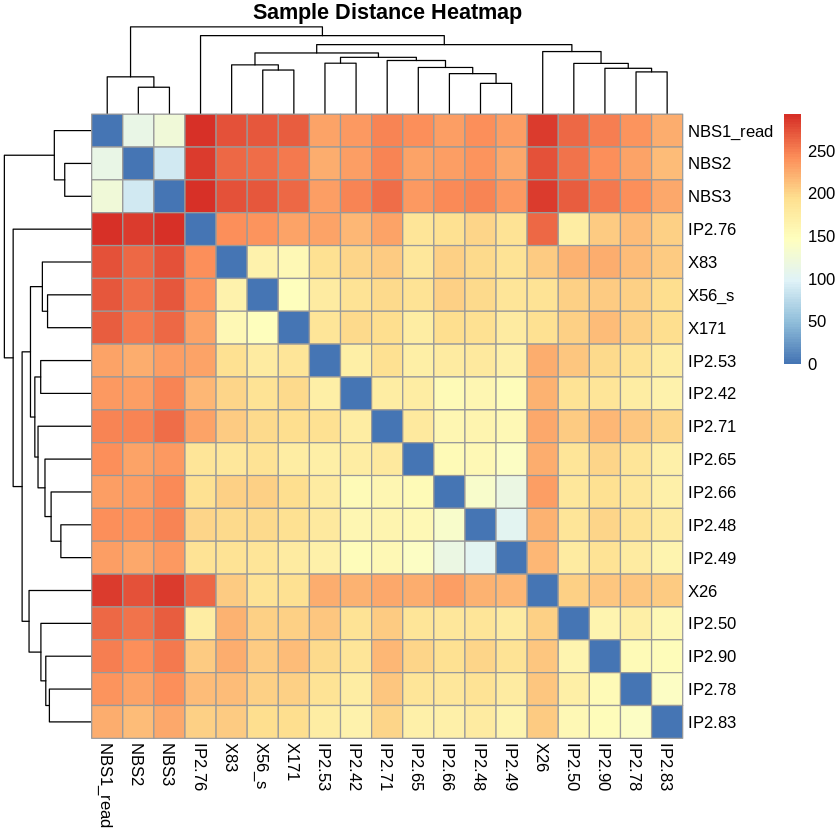

In [83]:
# Calculate sample distances using the variance-stabilized data (vsd).
sampleDists <- dist(t(assay(vsd)))

# Convert the distances to a matrix for heatmap visualization.
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- colnames(dds)
colnames(sampleDistMatrix) <- colnames(dds)

# Plot a heatmap of sample-to-sample distances to assess overall sample similarity and batch effects.
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         main = "Sample Distance Heatmap")

### Generate MA plots to visualize the log2 fold change against the mean of normalized counts.

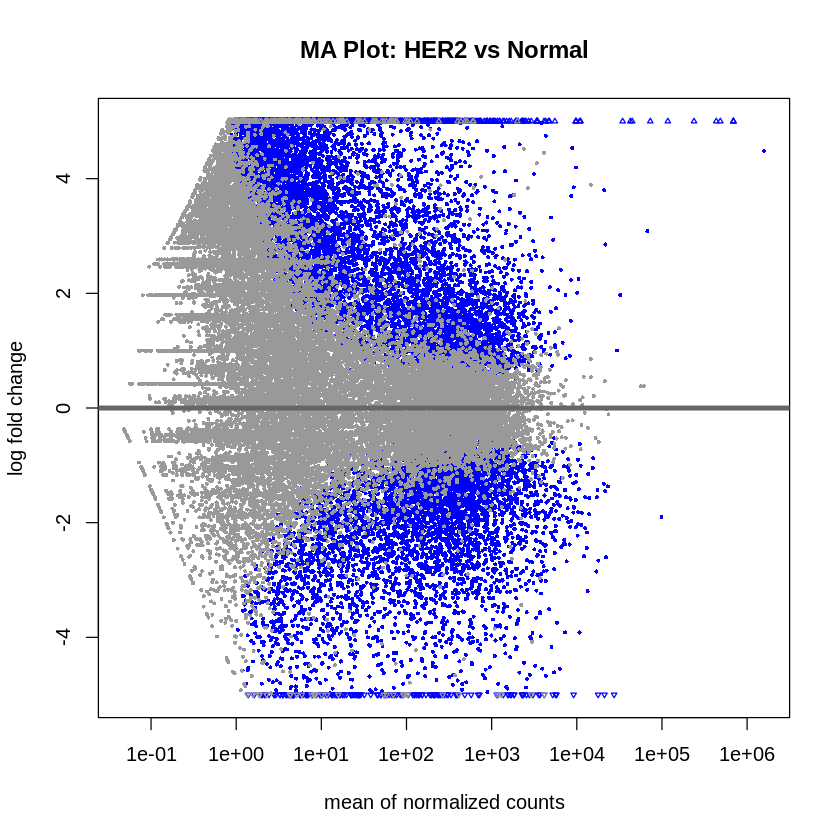

In [72]:
# These plots help to identify genes with significant differential expression.
plotMA(res_HER2_vs_Normal, main = "MA Plot: HER2 vs Normal", ylim = c(-5, 5))


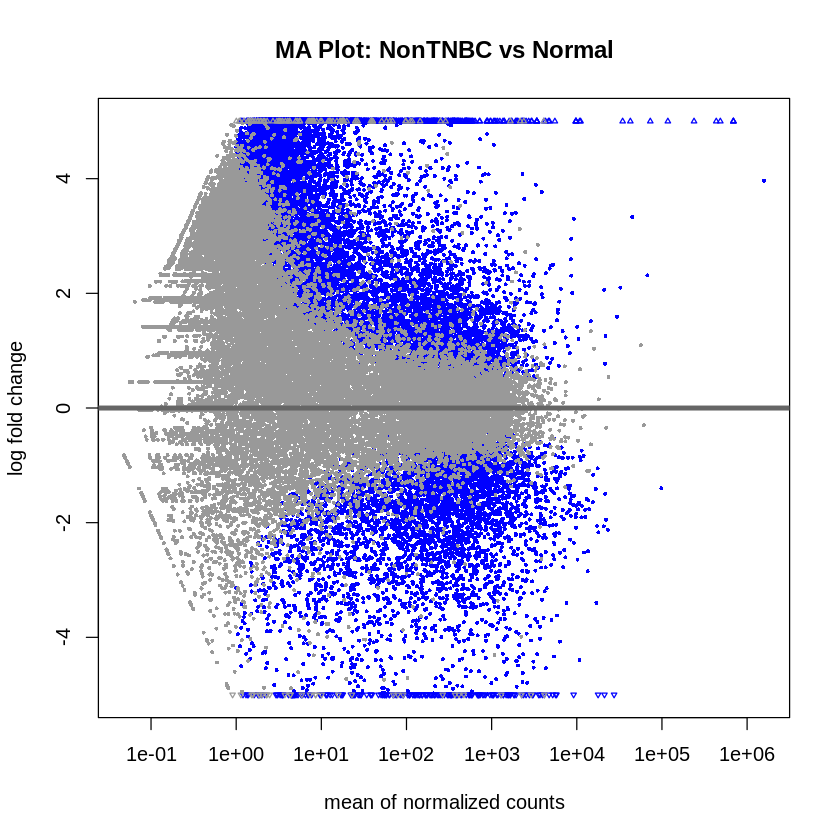

In [73]:
plotMA(res_NonTNBC_vs_Normal, main = "MA Plot: NonTNBC vs Normal", ylim = c(-5, 5))


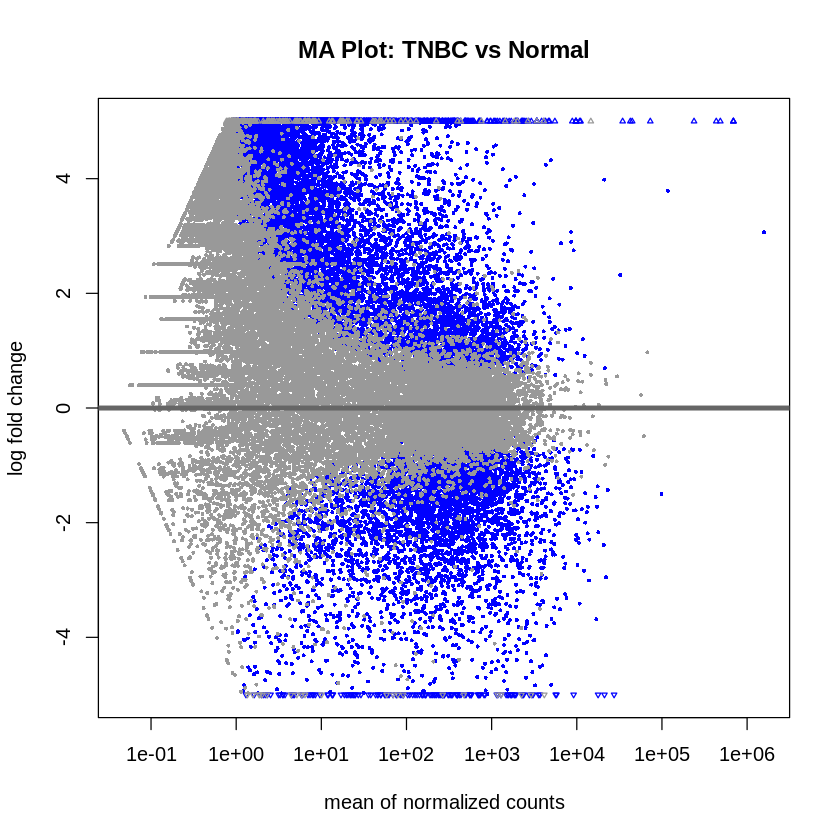

In [74]:
plotMA(res_TNBC_vs_Normal, main = "MA Plot: TNBC vs Normal", ylim = c(-5, 5))


### Generate Volcano plots to visualize the relationship between fold change and statistical significance.

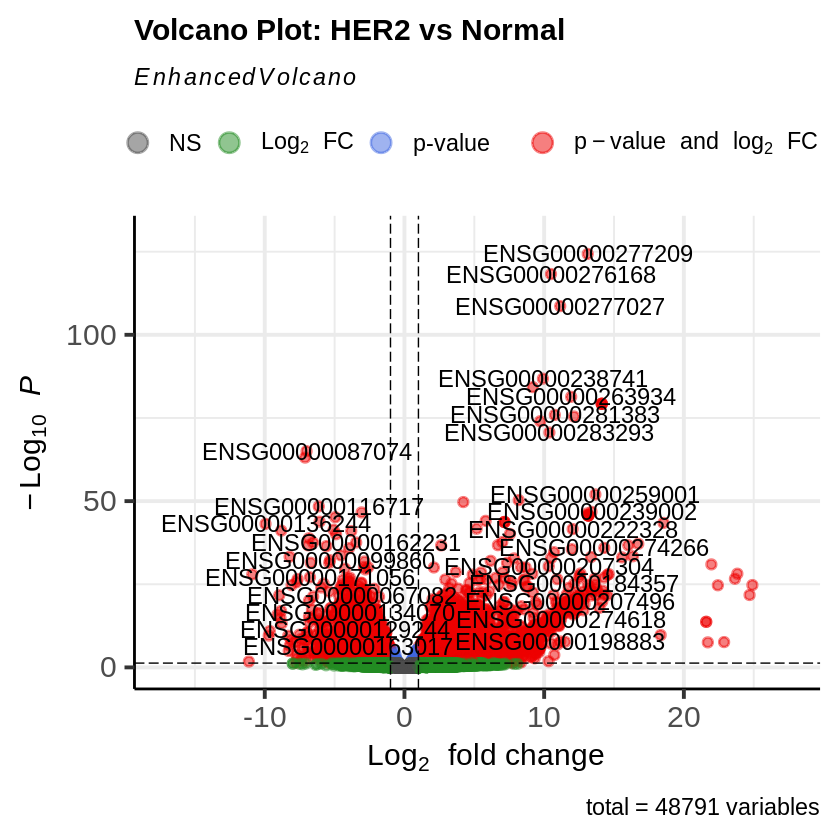

In [76]:
# Genes that are both highly differentially expressed and statistically significant will appear in the upper corners.
EnhancedVolcano(res_HER2_vs_Normal,
                lab = rownames(res_HER2_vs_Normal),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Volcano Plot: HER2 vs Normal',
                pCutoff = padj_threshold,
                FCcutoff = log2fc_threshold)


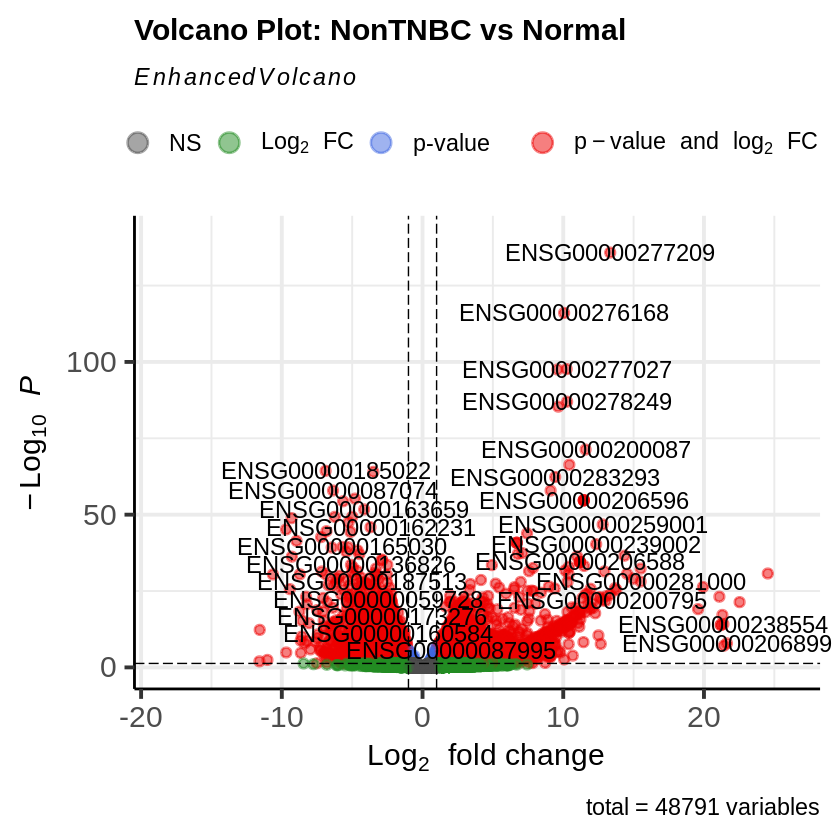

In [77]:
EnhancedVolcano(res_NonTNBC_vs_Normal,
                lab = rownames(res_NonTNBC_vs_Normal),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Volcano Plot: NonTNBC vs Normal',
                pCutoff = padj_threshold,
                FCcutoff = log2fc_threshold)

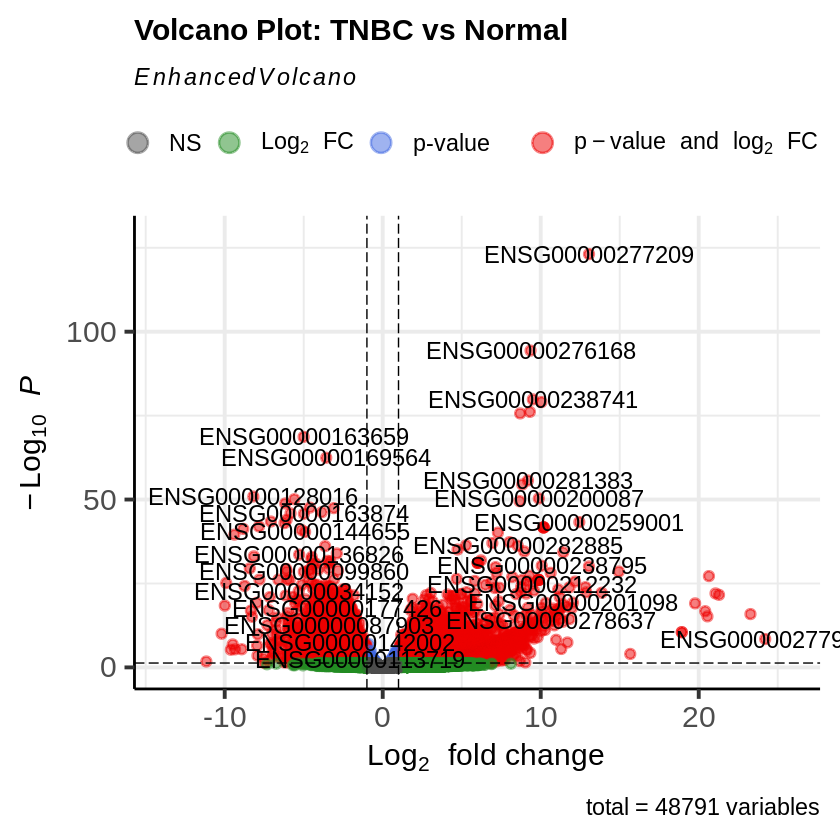

In [78]:
EnhancedVolcano(res_TNBC_vs_Normal,
                lab = rownames(res_TNBC_vs_Normal),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'Volcano Plot: TNBC vs Normal',
                pCutoff = padj_threshold,
                FCcutoff = log2fc_threshold)

### Performing Variance Stabilizing Transformation (VST) on the DESeqDataSet.

using ntop=500 top features by variance



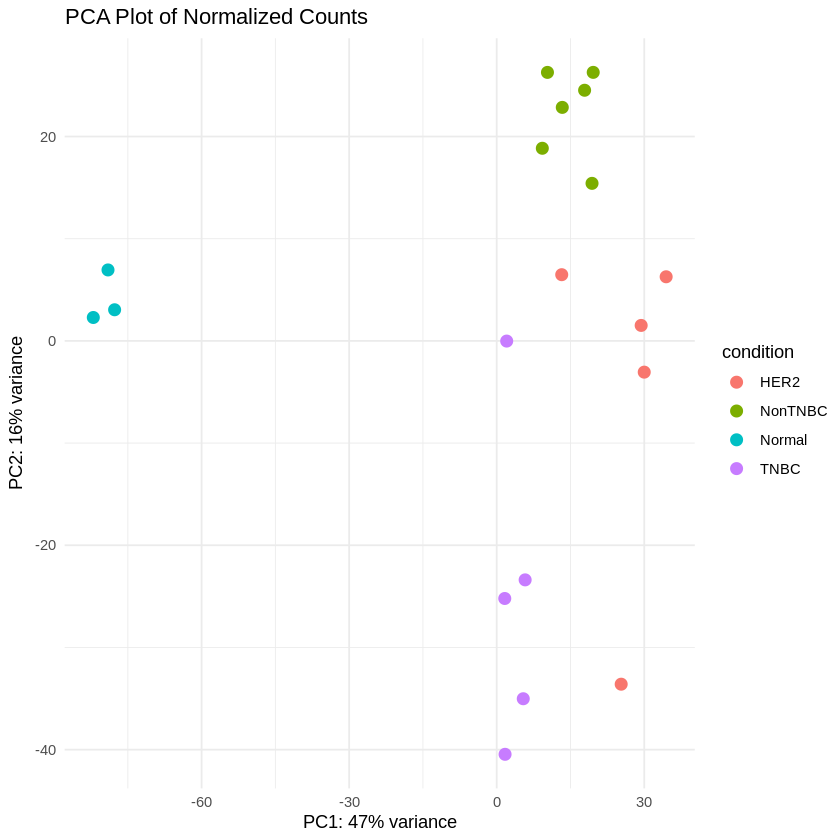

In [65]:
# VST helps to make the data homoscedastic, which is beneficial for PCA and clustering.
vsd <- vst(dds, blind = FALSE)
# Perform Principal Component Analysis (PCA) on the VST-transformed data.
pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
# Calculate the percentage of variance explained by each principal component.
percentVar <- round(100 * attr(pcaData, "percentVar"))

# Plot the PCA results using ggplot2 to visualize sample clustering based on experimental conditions.
ggplot(pcaData, aes(PC1, PC2, color = condition)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal() +
  ggtitle("PCA Plot of Normalized Counts")

### Performing Gene Ontology (GO) enrichment analysis using clusterProfiler.

In [66]:
# This identifies over-represented GO terms (Biological Process, Cellular Component, Molecular Function)
# among the significant DEGs for HER2 vs Normal.
go_enrich_HER2 <- enrichGO(gene = gene_list_HER2_entrez$ENTREZID,
                           OrgDb = org.Hs.eg.db,
                           keyType = "ENTREZID",
                           ont = "ALL", # Analyze all three GO ontologies
                           pAdjustMethod = "BH",
                           qvalueCutoff = 0.05,
                           readable = TRUE) # Convert Entrez IDs to gene symbols for readability

# View the top GO enrichment results
head(go_enrich_HER2)

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002181,BP,GO:0002181,cytoplasmic translation,124/6343,208/18860,0.5961538,1.772578,7.975681,1.181412e-14,7.524410e-11,6.321174e-11,RPL36A/YBX3/RPL28/RPS28/EIF3F/ETF1/RPL4/RPS13/EIF3G/RPL27A/RPS23/RPL18/RPL7A/YWHAG/RPLP2/EIF4A1/SARS1/RPS11/EEF2/RPL3/RPL12/RPLP1/RPS12/RPS4X/EIF3I/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/METTL18/RPL37/RPL32/EIF3L/RPS19/EIF3D/GTPBP1/GSK3B/RPL26/LIN28A/KCMF1/RPL14/RACK1/ASCC3/RPL13/RPL13A/ZNF385A/RPS6/EIF2D/RPL22/EIF4B/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/EEF1D/RPL17/RPL8/RPS27A/IGF2BP1/RPL24/MTOR/RPL23A/RPS16/RPS26/RPS2/HNRNPD/RPL5/RPL7/EIF3A/MCTS1/RPL36/EIF3H/RPS14/EIF5/UBA52/RPS18/TBK1/RPL6/RPL15/RNH1/RPS8/RPS27/FTSJ1/CNBP/RPL11/EIF3J/RPL34/PAIP1/RRAGA/RPL38/RPL41/EIF3K/EIF3C/EIF3CL/RPS10/RPL27/ANG/UBR4/RPS24/RPL30/RPS20/RPL31/EIF2B2/RPL35A/RRAGC/HHEX/RHEB/EIF2S3B/GPR155/RPS17/YBX1/RBM4/CPEB2/RBM24/RPS21/NMNAT2/NEMF/RPS29,124
GO:0002443,BP,GO:0002443,leukocyte mediated immunity,242/6343,488/18860,0.4959016,1.474492,7.559925,1.302113e-13,4.146577e-10,3.483494e-10,IL6/PIK3CG/TICAM1/CD84/BCL3/CCR2/NCKAP1L/CD226/PTPRC/ICAM1/FCGR2B/BCL6/CLCF1/STXBP1/TIGIT/ARID5A/SASH3/FERRY3/SCIMP/FCGR3A/SLAMF6/TLR8/TNF/BCL10/HLA-E/FCGR1A/VAMP2/YWHAG/PTGDR/LILRB4/SPN/NECTIN2/ATAD5/LILRB1/BTK/RNF19B/HAVCR2/GNL1/SANBR/CLEC7A/CD55/NFKBIZ/SLAMF7/CD27/FCGR3B/EXO1/CD19/F2RL1/MYO1G/CD80/STX4/PARP3/DENND1B/KLRD1/IL18/CD2/CR1/IL1B/CD81/STAT5A/SWAP70/IGHG3/CORO1A/IGHV3-23/IGHV3-11/IGHV3-21/SH2D1A/BATF/TUBB4B/CLU/STAP1/IL6R/RIF1/HMCES/IGHG1/LYST/RASGRP1/CLNK/CD96/CD160/FCGR1BP/C1QB/CALHM6/LAT2/NBN/IL12RB1/ITGB2/IGHV3-30/C4BPA/JAK3/NCF1/DNASE1L3/IGLC1/C1QA/CYRIB/NR4A3/IGKC/IGLL5/STAT6/PMS2/IGLC2/APLF/IGHV3-7/FCGR2A/VAV1/MAPK3/IGHV3-48/TREM1/TGFB1/MILR1/KLRC1/EXOSC3/PLEKHM2/IGHV1-69D/STX7/PTGDS/IGHV1-18/IGLC7/IGLC3/IGHV4-59/IGHV4-61/FUT7/EXOSC6/CD28/ITGAM/C1QC/FCER1G/SECTM1/C1RL/IGHV5-51/AZGP1/LAG3/CTSC/IGHV4-34/IL21/TYROBP/AGER/ERCC1/IGHV3-15/IGHV4-39/PIK3R6/IL23A/STAT5B/ZP3/IGHV3-74/GAB2/SYK/STXBP2/RAET1L/CRK/SH2D1B/CSF2RB/CD1A/TNFSF4/IGHG2/KLRK1/KLRC4-KLRK1/SCNN1B/MSH2/CD40/IL4R/SPI1/SERPINB9/HSPD1/IGHV3-73/CD1C/NCR1/RSAD2/C1R/IL18RAP/IGHV1-3/AICDA/SLA2/IGHV2-5/RIGI/KLRC4/DDX21/RABGEF1/HPX/CEACAM1/IL7R/RASGRP4/IGHV1-58/CR2/CFI/IGHV3-13/P2RX7/IGHV6-1/LTA/CD74/PIK3CB/AZU1/CPLX2/TRAF3IP2/FOXF1/KMT5C/GRP/IL1R1/WAS/CD1D/SMAD7/UNC93B1/CD300A/IGHV3-49/IGHV4-28/FES/AHR/DDX1/IL9R/IGHV3-64D/IL23R/CD1E/NLRP3/IGHV4-4/CD1B/JAG1/IGHV1-69/C2/CD40LG/ULBP1/RAET1E/FADD/KLRC2/KIT/IL2RB/DNASE1/FCMR/GZMB/LAT/CCL3/IGHV3-20/MBL2/CD8A/CX3CR1/ARG1/ADORA2B/C4A/NKG7/C4BPB/SLC18A2/HLA-A/MICA,242
GO:0002460,BP,GO:0002460,adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains,205/6343,402/18860,0.5099502,1.516264,7.448160,3.277226e-13,6.957551e-10,5.844962e-10,ZC3H12A/IL6/BCL3/CCR2/JUNB/BRD2/NCKAP1L/CD226/SOCS3/PTPRC/ICAM1/FCGR2B/BCL6/CLCF1/NFKB2/ARID5A/SASH3/FCGR3A/SLAMF6/TLR8/TNF/BCL10/HLA-E/FCGR1A/YWHAG/LILRB4/SPN/NECTIN2/ATAD5/TNFAIP3/LILRB1/BTK/HLX/LY9/TNFSF13B/HAVCR2/KLHL6/GNL1/SANBR/CLEC7A/CD55/NFKBIZ/CD27/FCGR3B/EXO1/CD19/MYO1G/CD80/SLC11A1/PARP3/DENND1B/KLRD1/IL18/CR1/IL1B/RELB/ANXA1/CD81/STAT5A/SWAP70/IGHG3/IGHV3-23/IGHV3-11/IGHV3-21/BATF/CLU/IL6R/RIF1/HMCES/IGHG1/RC3H2/FCGR1BP/C1QB/NBN/IL12RB1/IRF4/IGHV3-30/C4BPA/JAK3/IGLC1/RC3H1/C1QA/CYRIB/BACH2/IL6ST/IGKC/IGLL5/STAT6/PMS2/IGLC2/APLF/MTOR/IGHV3-7/FCGR2A/MAPK3/STAT3/IGHV3-48/ASCL2/TGFB1/KLRC1/EXOSC3/IGHV1-69D/RIPK2/STX7/EPHB2/TYK2/IGHV1-18/IGLC7/IGLC3/IGHV4-59/IGHV4-61/FUT7/EXOSC6/CD28/C1QC/FCER1G/NFKBID/SECTM1/C1RL/IGHV5-51/AZGP1/SYVN1/CTSC/IGHV4-34/AGER/ERCC1/IGHV3-15/CLEC6A/IGHV4-39/IL23A/ZP3/IGHV3-74/RAET1L/CSF2RB/CD1A/TNFSF4/IGHG2/BRD4/MSH2/CD40/IL4R/HSPD1/IGHV3-73/CD1C/ENTPD7/RSAD2/C1R/IGHV1-3/AICDA/SLA2/IGHV2-5/HPX/CEACAM1/IL1RL1/SEMA4A/IL7R/IGHV1-58/CR2/CFI/IGHV3-13/P2RX7/IGHV6-1/LTA/CD74/PRKCQ/TRAF3IP2/KMT5C/JAK2/IL1R1/WAS/

### Performing KEGG pathway enrichment analysis.

In [67]:
# This identifies over-represented KEGG pathways among the significant DEGs for HER2 vs Normal.
kegg_enrich_HER2 <- enrichKEGG(gene = gene_list_HER2_entrez$ENTREZID,
                               organism = 'hsa', # 'hsa' for Homo sapiens
                               pAdjustMethod = "BH",
                               qvalueCutoff = 0.05)

# View the top KEGG enrichment results
head(kegg_enrich_HER2)

kegg_category.rda is not found, download it online...



,category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05171,Human Diseases,Infectious disease: viral,hsa05171,Coronavirus disease - COVID-19,130/3020,238/9522,0.5462185,1.722216,7.689699,1.191755e-13,4.159226e-11,3.274191e-11,3569/6173/1440/1839/51284/4792/3725/5970/6158/6347/6234/6124/6207/6157/51311/5579/6228/7124/2353/1536/6141/6130/6181/4793/6205/6122/719/6136/6176/6206/6191/6168/6134/6209/6142/6193/6166/6230/2197/3553/6167/6161/1432/6223/6154/7132/3570/9045/6137/23521/713/6194/6146/6175/6159/4736/6188/6203/6144/6139/6132/6233/712/1675/3572/6152/59272/6147/6217/6231/3627/6187/2212/5595/6774/6125/6129/25873/103/6208/7297/4790/6772/5648/7311/6222/714/5610/29110/4938/6128/6138/6202/340061/6850/6232/6135/6164/100529097/2162/715/6169/6171/23586/6204/6155/9641/185/6229/6156/4939/6224/2243/5291/6160/3661/6403/6165/3455/114548/717/6218/3576/5582/6227/4153/720/110384692/6235/4940,130
hsa04613,Organismal Systems,Immune system,hsa04613,Neutrophil extracellular trap formation,109/3020,196/9522,0.5561224,1.753443,7.263602,2.557652e-12,4.463103e-10,3.513406e-10,8367/8338/8370/3013/333932/8329/317772/8336/8357/8343/8332/8347/8362/8348/8363/8364/51284/8969/8330/5970/8366/8346/8360/8358/85235/121504/8340/8365/8351/8356/8354/126961/8331/128312/8350/8968/3012/8355/3018/71/8345/5604/8361/8359/2359/8339/2214/51311/5579/1536/8335/8352/8368/2209/8342/653604/4688/8344/8970/3017/51564/27180/64581/10014/8294/8341/55869/293/3014/2215/124905743/3683/8334/440689/1378/83933/1432/3689/653361/1184/3021/2475/5330/60/2212/5595/10013/8353/9734/4790/5605/3684/177/2358/6850/723790/7417/292/2243/5291/6404/566/10105/6403/2357/5582/4689/366/820,109
hsa05322,Human Diseases,Immune disease,hsa05322,Systemic lupus erythematosus,82/3020,144/9522,0.5694444,1.795447,6.554788,2.774459e-10,3.227621e-08,2.540820e-08,8367/8338/8370/3013/333932/8329/317772/8336/8357/8343/8332/8347/8362/8348/8363/8364/8969/8330/8366/8346/8360/8358/85235/121504/8340/8365/8351/8356/8354/126961/8331/128312/8350/8968/3012/8355/3018/8345/8361/8359/8339/2214/7124/8335/8352/8368/2209/8342/653604/8344/8970/87/3017/6738/8294/8341/3014/2215/124905743/942/941/8334/440689/3109/81/6628/713/712/3021/3111/2212/8353/940/714/723790/958/715/2904/717/959/720/110384692,82
hsa05034,Human Diseases,Substance dependence,hsa05034,Alcoholism,99/3020,191/9522,0.5183246,1.634267,6.034567,4.618315e-09,4.029480e-07,3.172053e-07,8367/8338/8370/3013/333932/8329/317772/8336/8357/8343/8332/8347/8362/8348/8363/8364/8969/8330/8366/8346/8360/8358/85235/121504/8340/8365/8351/8356/8354/126961/8331/128312/8350/8968/3012/8355/3018/8345/468/5604/8361/8359/8339/8335/8352/8368/8342/653604/814/8344/8970/3017/51564/10014/8294/8341/55869/3014/8334/440689/83933/2788/9586/369/3021/6464/2770/5595/2787/10013/8353/9734/59345/627/2771/10488/2783/723790/10681/4128/808/25759/4915/2904/1813/1812/3265/4129/810/116443/2793/6570/90993/2906/136/6571/5567/55970/111,99
hsa04061,Environmental Information Processing,Signaling molecules and interaction,hsa04061,Viral protein interaction with cytokine and cytokine receptor,59/3020,100/9522,0.5900000,1.860258,5.893572,1.478266e-08,1.031829e-06,8.122680e-07,3569/2920/729230/2921/1230/6347/8793/7124/6358/1233/1435/1234/6376/8795/6362/3606/2829/6364/7132/3570/3587/4283/3572/3627/3561/6373/4055/57007/1237/3559/1436/2833/56477/8797/6387/3579/2919/1232/2826/8764/6366/8807/10803/4049/146433/6374/10563/3576/3560/6348/9560/388372/1524/6355/6349/414062/6354/3577/9547,59
hsa04060,Environmental Information Processing,Signaling molecules and interaction,hsa04060,Cytokine-cytokine receptor interaction,137/3020,298/9522,0.4597315,1.449524,5.373077,1.219576e-07,7.093866e-06,5.584373e-06,3569/2920/3976/1440/729230/2921/1230/6347/23529/85480/8793/7124/6358/1233/1435/1234/6376/10673/3563/608/939/4804/8795/50615/8742/6362/3606/2829/3553/6364/4982/944/7132/3570/3624/3587/3

In [68]:
# Perform Reactome pathway enrichment analysis.
# This identifies over-represented Reactome pathways among the significant DEGs for HER2 vs Normal.
reactome_enrich_HER2 <- enrichPathway(gene = gene_list_HER2_entrez$ENTREZID,
                                      organism = "human",
                                      pAdjustMethod = "BH",
                                      qvalueCutoff = 0.05,
                                      readable = TRUE) # Convert Entrez IDs to gene symbols for readability

# View the top Reactome enrichment results
head(reactome_enrich_HER2)

,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-72689,R-HSA-72689,Formation of a pool of free 40S subunits,81/3964,102/11230,0.7941176,2.249733,9.364798,6.338338e-20,1.025517e-16,8.802011e-17,RPL36A/RPL28/RPS28/EIF3F/RPL4/RPS13/EIF3G/RPL27A/RPS23/RPL18/RPL7A/RPLP2/RPS11/RPL3/RPL12/RPLP1/RPS12/RPS4X/EIF3I/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/RPL37/RPL32/EIF3L/RPS19/EIF3D/RPL26/RPL14/RPL13/RPL13A/RPS6/RPL22/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/RPL17/RPL8/RPS27A/RPL24/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/EIF3A/RPL36/EIF3H/RPS14/UBA52/RPS18/RPL6/RPL15/RPS8/RPS27/RPL11/EIF3J/RPL34/RPL38/RPL41/EIF3K/EIF3C/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/RPL35A/RPS17/RPS21/RPS29,81
R-HSA-156842,R-HSA-156842,Eukaryotic Translation Elongation,76/3964,94/11230,0.8085106,2.290508,9.280038,1.213630e-19,1.025517e-16,8.802011e-17,RPL36A/RPL28/RPS28/RPL4/RPS13/RPL27A/RPS23/RPL18/RPL7A/RPLP2/RPS11/EEF2/RPL3/RPL12/RPLP1/RPS12/RPS4X/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/RPL37/RPL32/RPS19/RPL26/EEF1A1/RPL14/RPL13/RPL13A/RPS6/RPL22/EEF1G/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/EEF1D/RPL17/RPL8/RPS27A/RPL24/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/RPL36/RPS14/UBA52/RPS18/RPL6/RPL15/RPS8/RPS27/RPL11/RPL34/RPL38/RPL41/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/EEF1B2/RPL35A/RPS17/RPS21/RPS29,76
R-HSA-156902,R-HSA-156902,Peptide chain elongation,73/3964,90/11230,0.8111111,2.297875,9.130642,4.530665e-19,2.325051e-16,1.995591e-16,RPL36A/RPL28/RPS28/RPL4/RPS13/RPL27A/RPS23/RPL18/RPL7A/RPLP2/RPS11/EEF2/RPL3/RPL12/RPLP1/RPS12/RPS4X/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/RPL37/RPL32/RPS19/RPL26/EEF1A1/RPL14/RPL13/RPL13A/RPS6/RPL22/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/RPL17/RPL8/RPS27A/RPL24/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/RPL36/RPS14/UBA52/RPS18/RPL6/RPL15/RPS8/RPS27/RPL11/RPL34/RPL38/RPL41/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/RPL35A/RPS17/RPS21/RPS29,73
R-HSA-9954716,R-HSA-9954716,ZNF598 and the Ribosome-associated Quality Trigger (RQT) complex dissociate a ribosome stalled on a no-go mRNA,77/3964,97/11230,0.7938144,2.248874,9.124058,5.503080e-19,2.325051e-16,1.995591e-16,UBC/RPL36A/RPL28/RPS28/RPL4/RPS13/UBE2D2/RPL27A/RPS23/RPL18/RPL7A/RPLP2/RPS11/RPL3/RPL12/RPLP1/RPS12/RPS4X/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/RPL37/RPL32/RPS19/RPL26/RPL14/ASCC3/RPL13/RPL13A/RPS6/RPL22/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/RPL17/RPL8/RPS27A/RPL24/UBB/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/RPL36/RPS14/UBA52/RPS18/RPL6/RPL15/RPS8/ZNF598/RPS27/RPL11/RPL34/RPL38/RPL41/UBE2D3/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/RPL35A/RPS17/RPS21/RPS29,77
R-HSA-72706,R-HSA-72706,GTP hydrolysis and joining of the 60S ribosomal subunit,85/3964,113/11230,0.7522124,2.131015,8.924905,3.896448e-18,1.316999e-15,1.130380e-15,RPL36A/RPL28/RPS28/EIF3F/RPL4/RPS13/EIF3G/RPL27A/RPS23/RPL18/RPL7A/RPLP2/EIF4A1/RPS11/RPL3/RPL12/RPLP1/RPS12/RPS4X/EIF3I/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/EIF4E/RPL37/RPL32/EIF3L/RPS19/EIF3D/RPL26/RPL14/RPL13/RPL13A/RPS6/RPL22/EIF4B/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/RPL17/RPL8/RPS27A/RPL24/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/EIF3A/RPL36/EIF3H/RPS14/EIF5/UBA52/RPS18/RPL6/RPL15/RPS8/RPS27/RPL11/EIF3J/RPL34/RPL38/RPL41/EIF3K/EIF3C/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/RPL35A/RPS17/RPS21/RPS29,85
R-HSA-2408557,R-HSA-2408557,Selenocysteine synthesis,74/3964,94/11230,0.7872340,2.230232,8.846590,6.449512e-18,1.557097e-15,1.336455e-15,RPL36A/RPL28/RPS28/RPL4/RPS13/RPL27A/RPS23/RPL18/RPL7A/RPLP2/SARS1/RPS11/RPL3/RPL12/RPLP1/RPS12/RPS4X/RPL37A/RPL10/RPS15/RPL18A/RPS5/RPL36AL/RPS25/FAU/RPL37/RPL32/RPS19/RPL26/RPL14/RPL13/RPL13A/RPS6/RPL22/RPLP0/RPL29/RPL10A/RPS3/RPS9/RPL21/RPL17/RPL8/RPS27A/RPL24/RPL23A/RPS16/RPS26/RPS2/RPL5/RPL7/RPL36/RPS14/UBA52/RPS18/RPL6/RPL15/RPS8/RPS27/RPL11/RPL34/RPL38/SEPSECS/RPL41/RPS10/RPL27/RPS24/RPL30/RPS20/RPL31/RPL35A/RPS17/SEPHS2/RPS21/RPS29,74


### Generate a dot plot to visualize the top GO enrichment results.

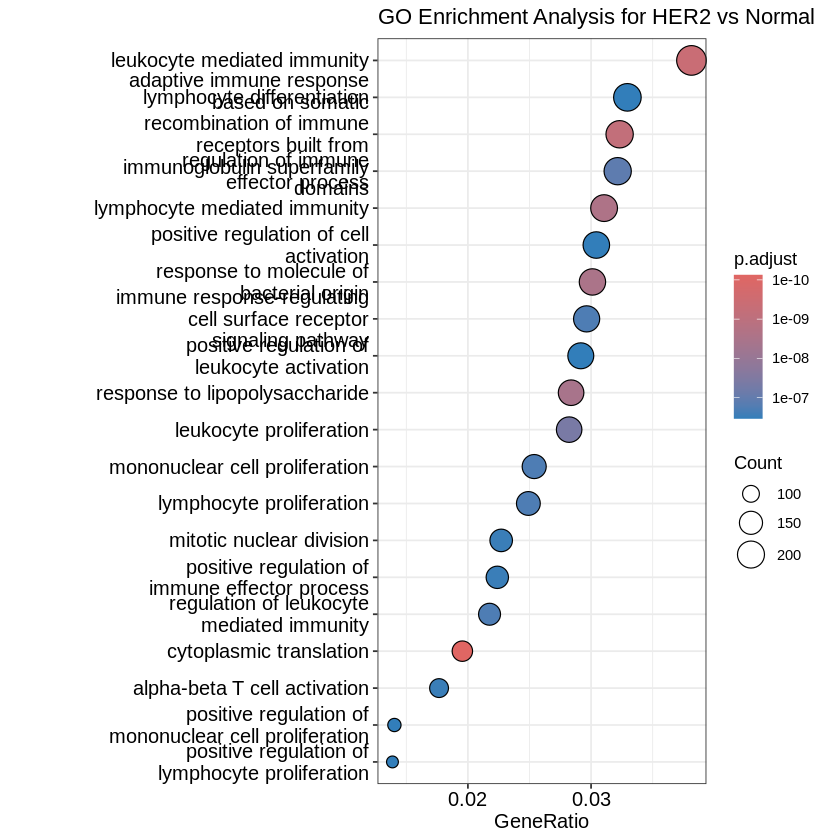

In [69]:
# The plot shows enriched terms, gene counts, and enrichment significance.
dotplot(go_enrich_HER2, showCategory = 20) + ggtitle("GO Enrichment Analysis for HER2 vs Normal")

### Visualize a specific KEGG pathway using pathview.

In [81]:
pathview(gene.data = sig_HER2_vs_Normal$log2FoldChange,
         pathway.id = "hsa05200", # Example: 'Pathways in cancer'
         species = "hsa",
         limit = list(gene=max(abs(sig_HER2_vs_Normal$log2FoldChange)), cpd=1),
         bins = list(gene=10, cpd=10), # Number of bins for coloring
         low = list(gene = "green", cpd = "blue"), # Color for low expression
         high = list(gene = "red", cpd = "yellow"), # Color for high expression
         mid = list(gene = "gray", cpd = "gray")) # Color for middle expression


Argument gene.idtype or cpd.idtype may be wrong.

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /content

Info: Writing image file hsa05200.pathview.png

Info: some node width is different from others, and hence adjusted!



### Generate a bar plot to visualize the top Reactome enrichment results.

Warning message in (function (model, data, ...) :
“Arguments in `...` must be used.
✖ Problematic argument:
• by = "Count"
ℹ Did you misspell an argument name?”


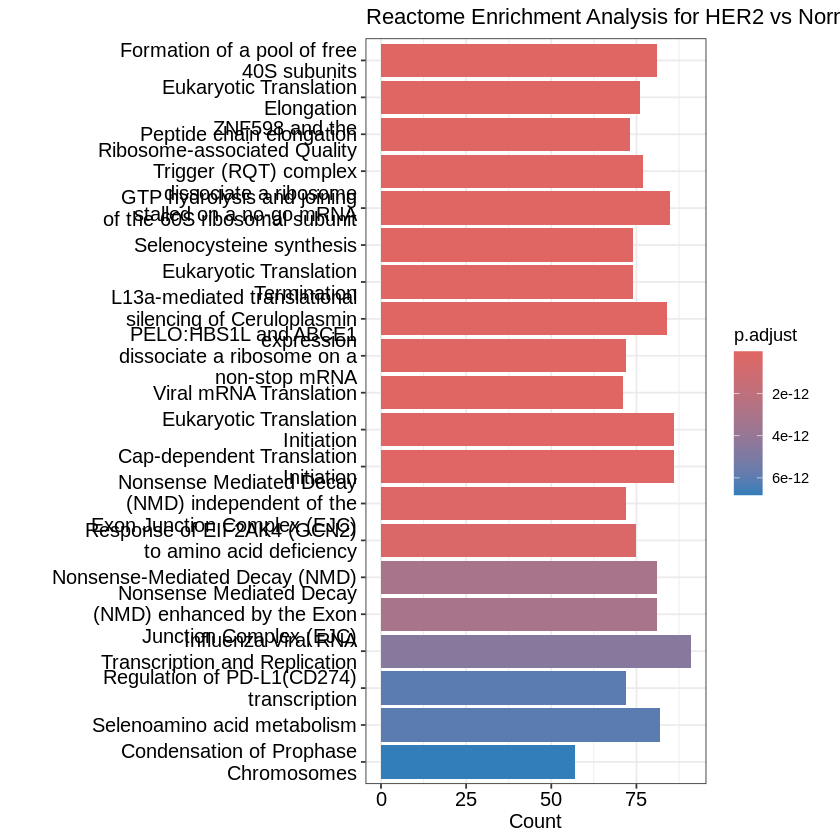

In [71]:

barplot(reactome_enrich_HER2, showCategory = 20) + ggtitle("Reactome Enrichment Analysis for HER2 vs Normal")